<a href="https://colab.research.google.com/github/RafiKepecs/Bayesian-Machine-Learning/blob/main/Project%202%3A%20Bayesian%20Linear%20Regression/BayesML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

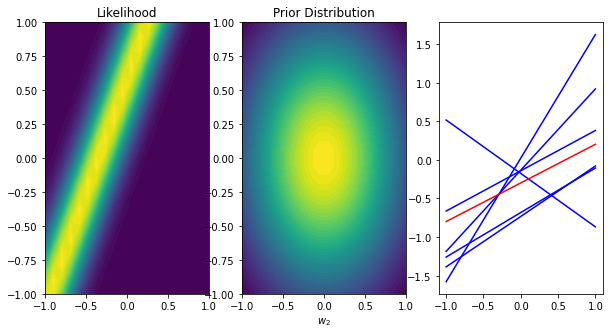

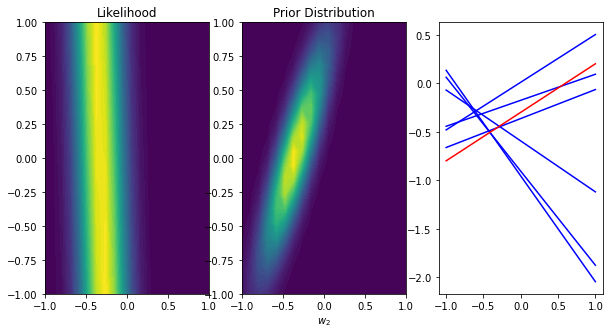

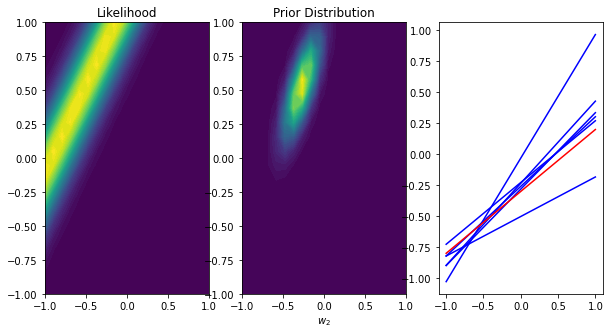

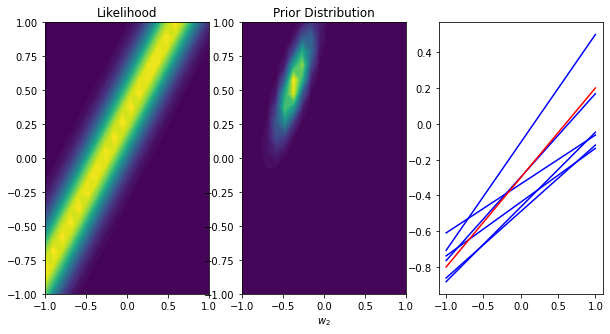

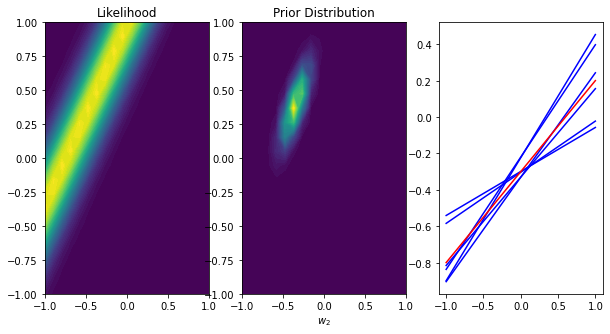

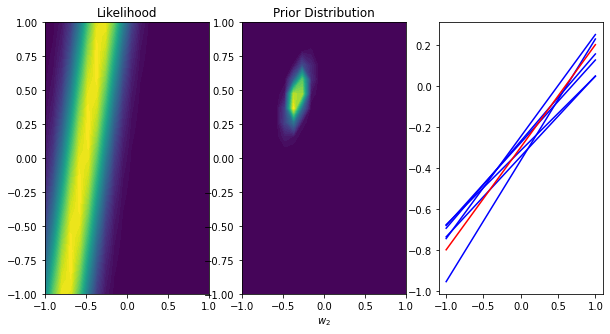

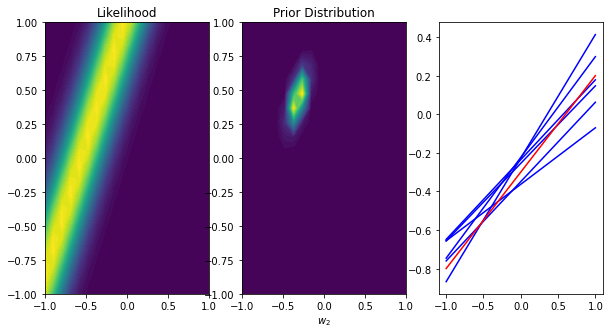

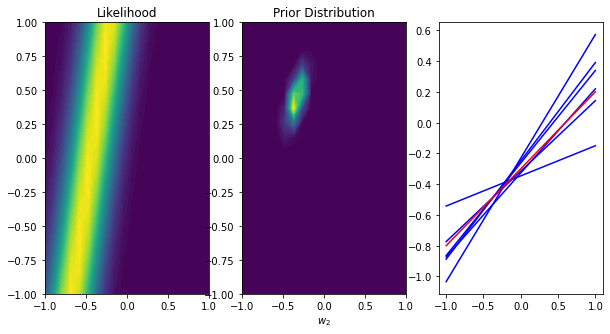

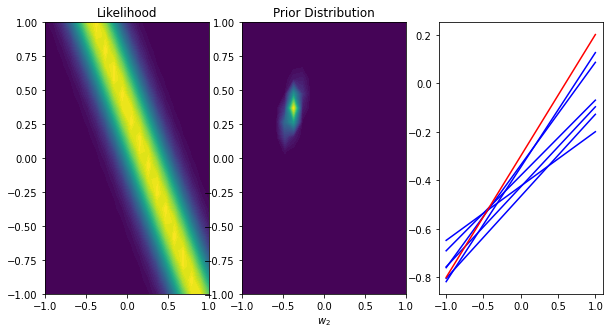

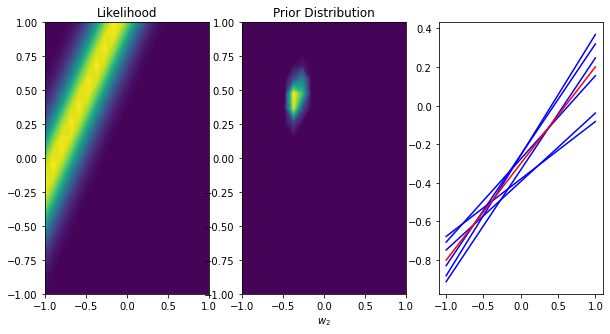

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random as random
import scipy.stats as stats
 
#number of samples
N = 20
x = np.linspace(-1, 1, 1000)
 
# Generate values of xn from uniform distribution from -1 to 1
X = np.array([[1, i] for i in np.random.uniform(-1,1, N)])
 
# Parameter values
a0 = -0.3
a1 = 0.5
a = np.array([a0, a1]).T
 
# Evaluate f(xn, a)
F = a @ X.T
 
# Add Gaussian noise with standard deviation of 0.2 to obtain the target values tn
alpha = 2.0
beta = 25
 
noise = np.random.normal(0,1/np.sqrt(beta),N)
 
T = np.transpose(F + noise)
 
# Iota matrix
iota = np.array([ X[i] for i in range(N) ])
 
# m and S
S, m = [],[]
 
S_inv = alpha*np.identity(2)
S.append(np.linalg.inv(S_inv))
m.append(np.array([0, 0]).T)
 
for i in range(1,N):
    S_inv = alpha*np.identity(2) + beta*(iota[:i].T @ iota[:i])
    S.append(np.linalg.inv(S_inv))
    m.append(beta * S[-1] @ iota[:i].T @ T[:i])
 
w = np.linspace(-1, 1, N)
W = np.dstack(np.meshgrid(w, w))
 
for i in np.linspace(0, N-1, 10, dtype=int):
 
    # Create new figure
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
 
    # Plot likelihood
    likelihood = np.squeeze(stats.norm(W @ X[i], 1/np.sqrt(beta)).pdf(T[i]))
    axs[0].contourf(w, w, likelihood, 50)
    axs[0].set_title("Likelihood")
 
    # Plot prior distribution
    priors = stats.multivariate_normal(m[i].flatten(), S[i]).pdf(W)
    axs[1].contourf(w, w, priors, 50)
    axs[1].set_title('Prior Distribution')
    axs[1].set_xlabel('$w_1$')
    axs[1].set_xlabel('$w_2$')
 
    # Plot samples
    for j in range(6):
        prior_samples = np.random.multivariate_normal(m[i], S[i], N)
        y_samples = prior_samples[i, 0] + prior_samples[i, 1]*x
        axs[2].plot(x, y_samples, 'b')
 
    # Plot true parameter values
    f = np.random.multivariate_normal(m[i], S[i], N)
    f_samples = a0 + a1*x
    axs[2].plot(x, f_samples, 'r')

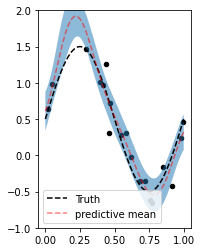

In [ ]:
#%%
import numpy as np
from matplotlib import pyplot as plt
import random as random
import scipy.stats as stats

#%% Function Definitions
def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)
#%% Parameters
N = 20

beta = 25.0
alpha = 2.0

#%% Original Sinusoid
X_space = np.linspace(0, 1, 1000).reshape(1000,1)
t_true = 0.5 + np.sin(2 * np.pi * X_space)
plt.plot(X_space, t_true)

#%% Phi matrix generation of original sinudoid
Phi_orig = []
Phi_orig.append(np.array([1]*len(X_space)).reshape(1000,1))
for i in np.linspace(0,1,9):
    Phi_orig.append(gaussian_basis_function(X_space, i, sigma = 0.1))
Phi_orig = np.array(Phi_orig).reshape(10,1000).T

#%% Generate sinusoidal observations with noise
X = np.random.rand(N, 1)
noise = np.random.normal(0, np.sqrt(1/beta), N)
f_obs = 0.5 + np.sin(2 * np.pi * X)
t = np.array([f_obs[i] + noise[i] for i in range(N)])

#%% Phi matrix generation of observations
Phi_obs = []
Phi_obs.append(np.array([1]*len(X)).reshape(N,1))
for i in np.linspace(0,1,9):
    Phi_obs.append(gaussian_basis_function(X, i, sigma = 0.1))
Phi_obs = np.array(Phi_obs).reshape(10,N).T

#%% m and S of the posterior distribution
S_inv = alpha * np.eye(Phi_obs.shape[1]) + beta * Phi_obs.T@Phi_obs
S = np.linalg.inv(S_inv)
m = beta * S@Phi_obs.T@t

#%% mean and variance of posterior predictive distribution
mean = Phi_orig @ m
# Only compute variances (diagonal elements of covariance matrix)
var = 1 / beta + np.sum(Phi_orig @ S * Phi_orig, axis=1) #!!!!

#%% Samples
w_samples = np.random.multivariate_normal(m.ravel(), S, 5).T
y_samples = Phi_orig.dot(w_samples)

#%% Plots
plt.subplot(1, 2, 1)
plt.scatter(X, t, marker='o', c="k", s=20) # plot data
plt.plot(X_space, t_true, 'k--', label='Truth') # plot truth function

plot_mean = np.mean(y_samples, axis = 1)
plt.plot(X_space, mean, 'r--', alpha = 0.5, label = "predictive mean")
plt.fill_between(X_space.ravel(), mean.ravel() + np.sqrt(var), mean.ravel() - np.sqrt(var), alpha = 0.5)
plt.ylim(-1.0, 2.0)
plt.legend()


In [ ]:
#%% Evidence approximation


alpha_0 = 1e-10
beta_0 = 1e-10

max_iter=200


eigenvalues_0 = np.linalg.eigvalsh(Phi_obs.T@Phi_obs)

epsilon = 1e-5

beta = beta_0
alpha = alpha_0

alpha_prev = alpha + 2*epsilon

i = 0
while i < max_iter and np.abs(alpha-alpha_prev) > epsilon:
        i = i+1    
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        S_inv = alpha * np.eye(Phi_obs.shape[1]) + beta * Phi_obs.T@Phi_obs
        
        S = np.linalg.inv(S_inv)
        m = beta * S@Phi_obs.T@t

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m.T@m)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi_obs.dot(m)) ** 2)
        beta = 1 / beta_inv
            
print(f'Iterations = {i + 1}.') 
print(f'alpha = {alpha}')
print(f'beta= {beta}')    

Iterations = 8.
alpha = 2.903276120447607
beta= 16.96541673377054
